In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-g5gu0eac
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-g5gu0eac
  Resolved https://github.com/facebookresearch/detectron2.git to commit 94113be6e12db36b8c7601e13747587f19ec92fe
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filen

In [ ]:
import torch, torchvision
print(torch.cuda.is_available())
import os, pickle ,random
import cv2 as cv
import matplotlib.pyplot as plt

False


In [ ]:
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode

In [ ]:
config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
output_dir = "./instance_segmentation"
num_classes = 2
device = "cuda"

In [ ]:
train_dataset_name = "train_data"
train_images_path = "/content/drive/MyDrive/LILA BC/dataset/train"
train_json_annot_path = "/content/drive/MyDrive/LILA BC/dataset/train/train.json"
val_dataset_name = "val_data"
val_images_path = "/content/drive/MyDrive/LILA BC/dataset/val"
val_json_annot_path = "/content/drive/MyDrive/LILA BC/dataset/val/val.json"

In [ ]:
register_coco_instances(name = train_dataset_name, metadata = {},
                       json_file = train_json_annot_path,
                        image_root = train_images_path)

In [ ]:
register_coco_instances(name = val_dataset_name, metadata = {},
                       json_file = val_json_annot_path,
                        image_root = val_images_path)

In [ ]:
cfg_save_path = "IS_cfg.pickle"

In [ ]:
def plot_samples(dataset_name, n = 1):
    thing_list = [ 'Other', 'Larch']
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name).set(thing_classes=thing_list)

    for s in random.sample(dataset_custom, n):
        img = cv.imread(s["file_name"])
        v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale = 0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize = (5,10))
        plt.imshow(v.get_image())
        plt.show()

[06/21 11:07:42 d2.data.datasets.coco]: Loading /content/drive/MyDrive/LILA BC/dataset/train/train.json takes 8.61 seconds.
[06/21 11:07:42 d2.data.datasets.coco]: Loaded 1228 images in COCO format from /content/drive/MyDrive/LILA BC/dataset/train/train.json


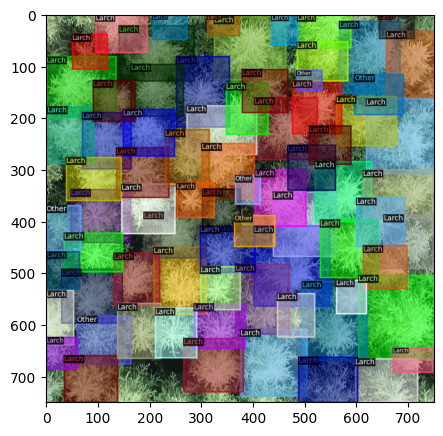

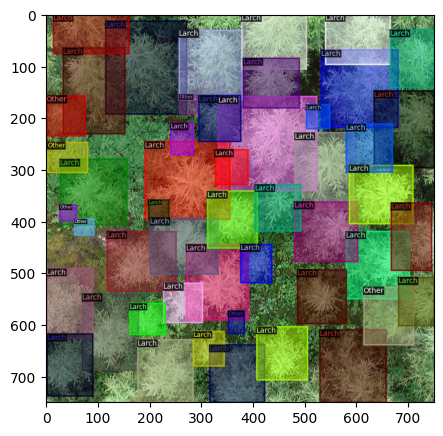

In [ ]:
#Verifying
plot_samples(dataset_name = train_dataset_name, n = 2)

In [ ]:
def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, val_dataset_name, num_classes, device, output_dir):
    cfg = get_cfg()

    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = (val_dataset_name,)

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.SOLVER.STEPS = []

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    return cfg

In [ ]:
def main():
    cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, val_dataset_name, num_classes, device, output_dir)

    with open(cfg_save_path,"wb") as f:
        pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

    os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume = False)

    trainer.train()

In [ ]:
main()

RuntimeError: ignored

In [ ]:
from detectron2.engine import DefaultPredictor
cfg_save_path = "IS_cfg.pickle"

with open(cfg_save_path, "rb") as f:
    cfg = pickle.load(f)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

In [ ]:
def on_image(image_path,predictor):
    im = cv.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], {"thing_classes":['Other', 'Larch']}, scale=0.5, instance_mode = ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize = (5,10))
    plt.imshow(v.get_image())

In [ ]:
image_path = "/content/drive/MyDrive/File Example/B01_0048.JPG"
on_image(image_path, predictor)

In [ ]:
image_path = "/content/drive/MyDrive/LILA BC/dataset/val/B01_0056.JPG"
on_image(image_path, predictor)